In [1]:
from geopy.distance import geodesic
import pandas as pd
import pandas as pd
import json
from dotenv import dotenv_values
import osmnx as ox
import networkx as nx
import sys
from datetime import datetime
import joblib

In [2]:
# 환경 변수 로드 함수
def config_load(keys):
    config = dotenv_values('.env')
    result = []
    for key in keys:
        result.append(config[key])

    return result

In [3]:
# 최단 대피소 탐색 함수
def distance_calculator(location, df, latitude, longitude):
    shelters = df.copy()

    def get_distance(row):
        dt = geodesic(location, (row[latitude], row[longitude])).km
        return dt

    shelters['distance'] = shelters.apply(get_distance, axis=1)
    min_distance = shelters['distance'].min()
    nearest = shelters.loc[shelters['distance'] == min_distance].iloc[0]

    return nearest

In [4]:
# GPS 좌표를 통해 최단 노드 탐색 함수
def find_nearest_node(row, G, col1, col2):
    row_col1 = row[col1]
    row_col2 = row[col2]
    node = None
    if row_col1 and row_col2:
        node = ox.nearest_nodes(G, row_col2, row_col1)
    
    return node

In [5]:
# 노드 ID를 통한 최단 경로 탐색 함수
def shortest_path(row, G):
    try:
        if (not row['학교_노드']) or (not row['대피소_노드']):
            result = None
        elif row['학교_노드'] == row['대피소_노드']:
            result = [row['학교_노드']]
        else:
            result = nx.shortest_path(G, row['학교_노드'], row['대피소_노드'])

    # 경로가 없는 경우 처리
    except nx.NetworkXNoPath as path_error:
        print(path_error)
        result = None
    
    except nx.NodeNotFound as node_error:
        print(node_error)
        result = None
    
    except Exception as e:
        print(e)
        sys.exit()
    
    return result

In [6]:
# 컬럼 별 None 값 확인 함수
def isna_some_cnt(cols, df, is_iterable=False):
    print()

    # 카운팅 함수(None인 경우 0을 반환)
    def len_row(row):
        if row:
            return len(row)
        else:
            return 0

    for col in cols:
        # 자료형이 배열(2차원) 형태인 경우
        if is_iterable:
            df_copy = df.copy()
            df_copy['cnt'] = df_copy[col].apply(len_row)
            cnt = df_copy.loc[df_copy['cnt']==0, 'cnt'].count()
            print(f'{col} 없는 개수: {cnt}')

        # 자료형이 스칼라 형태인 경우
        else:
            cnt = df[col].isna().sum()
            print(f'{col} 없는 개수: {cnt}')

In [7]:
# 전체 경로 거리 계산 함수
def whole_distance(route, G):
    result = None
    try:
        if route:
            if len(route) == 1:
                result = 0
            elif len(route) > 1:
                edge_lengths = ox.routing.route_to_gdf(G, route)
                result = edge_lengths['length'].sum()
    except Exception as e:
        print(f'error: {e}')
        result = None
    
    return result

In [8]:
# 현재 시간 표시 함수
def datetime_now():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [9]:
# 환경 변수 로드
keys = ['SAV_PATH', 'SHELTER_DATA']
[SAV_PATH, SHELTER_DATA] = config_load(keys)

# JSON 형식의 초등학교 GPS 좌표 정보 파일 로드
geo_dict = None
with open(SAV_PATH + 'geo_json.json', 'r', encoding='utf-8') as f:
    geo_dict = json.load(f)

geo_keys = geo_dict.keys()

In [10]:
# 대피소 정보 파일 로드
shelter_df = pd.read_excel(SHELTER_DATA).dropna().reset_index(drop=True)
shelter_df = shelter_df[shelter_df['도로명전체주소'].str.contains('서울특별시')].reset_index(drop=True)
shelter_df.head()

c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,번호,관리번호,지정일자,해제일자,운영상태,시설명,시설구분,도로명전체주소,소재지전체주소,도로명우편번호,...,위도(도),위도(분),위도(초),경도(도),경도(분),경도(초),위도(EPSG4326),경도(EPSG4326),좌표정보X(EPSG5179),좌표정보Y(EPSG5179)
0,5,3000000-S200700007,2009-12-15,2023-06-15,사용중지,청운효자동주민센터 지하1층,공공용시설,"서울특별시 종로구 자하문로 92, 청운효자동주민센터 지하1층 (궁정동)",서울특별시 종로구 궁정동 12-1 청운효자동주민센터,3047.0,...,37,35,2.71,126,58,14.18,37.584046,126.970614,953259.888856,1.953982e+06
1,7,3000000-S200700016,2009-12-15,2023-06-15,사용중지,구기터널,공공용시설,"서울특별시 종로구 진흥로 419, 구기터널관리사무소 (구기동)",서울특별시 종로구 구기동 117-41 구기터널관리사무소,3000.0,...,37,36,31.64,126,57,19.94,37.608790,126.955538,951944.673504,1.956735e+06
2,9,3000000-S200700024,2009-12-15,2023-06-15,사용중지,창신2동주민센터 지하1층,공공용시설,"서울특별시 종로구 창신길 62 (창신동, 창신제2동주민센터)",서울특별시 종로구 창신동 583번지 3호,3102.0,...,37,34,28.02,127,0,39.13,37.574401,127.010789,956801.414642,1.952893e+06
3,14,3000000-S200700034,2009-12-15,2023-06-15,사용중지,삼청동주민센터 지하1층 헬스장,공공용시설,"서울특별시 종로구 삼청로 107, 삼청동주민센터 지하1층 (삼청동)",서울특별시 종로구 삼청동 105-1 삼청동주민센터,3049.0,...,37,35,5.95,126,58,54.86,37.584996,126.981953,954261.613644,1.954082e+06
4,17,3000000-S200700047,2009-12-15,2023-06-15,사용중지,이화동주민센터 지하1층,공공용시설,"서울특별시 종로구 이화장길 33 (이화동, 이화동주민센터)",서울특별시 종로구 이화동 149번지 1호,3087.0,...,37,34,37.20,127,0,15.92,37.576925,127.004341,956233.521327,1.953176e+06


In [11]:
# 컬럼명 변수 선언
place_col = '시설명'
latitude_col = '위도(EPSG4326)'
longitude_col = '경도(EPSG4326)'

In [12]:
# 초등학교 GPS 정보 딕셔너리를 데이터프레임으로 변환
school_df = pd.DataFrame(geo_dict).T.reset_index().dropna()
school_df.columns = ['학교명', '학교_위도', '학교_경도']

# 초등학교 GPS 정보 데이터프레임에 추가 컬럼 생성
school_df['대피소명'] = ''
school_df['대피소_위도'] = None
school_df['대피소_경도'] = None
isna_some_cnt(['학교_위도', '학교_경도'], school_df)


학교_위도 없는 개수: 0
학교_경도 없는 개수: 0


In [13]:
# 초등학교 별 최단 거리 대피소 탐색
print(f'\n대피소 탐색 중 - {datetime_now()}\n')
fornum = 1
for location in geo_keys:
    if fornum % 100 == 1:
        print(f'{fornum}번째 학교의 대피소 탐색 중')
    
    school_point = geo_dict[location]

    # 가장 가까운 대피소 탐색
    nearest = distance_calculator(school_point, shelter_df, latitude_col, longitude_col)

    # 반환 받은 시리즈에서 대피소 정보 파싱
    place = nearest[place_col]
    latitude = nearest[latitude_col]
    longitude = nearest[longitude_col]

    # 파싱한 대피소 정보 할당
    school_df.loc[school_df['학교명']==location, '대피소명'] = place
    school_df.loc[school_df['학교명']==location, '대피소_위도'] = latitude
    school_df.loc[school_df['학교명']==location, '대피소_경도'] = longitude
    fornum += 1

print(f'전체 학교({fornum}개) 대피소 탐색 완료')
isna_some_cnt(['대피소_위도', '대피소_경도'], school_df)


대피소 탐색 중 - 2025-02-19 10:55:21

1번째 학교의 대피소 탐색 중
101번째 학교의 대피소 탐색 중
201번째 학교의 대피소 탐색 중
301번째 학교의 대피소 탐색 중
401번째 학교의 대피소 탐색 중
501번째 학교의 대피소 탐색 중
601번째 학교의 대피소 탐색 중
전체 학교(611개) 대피소 탐색 완료

대피소_위도 없는 개수: 0
대피소_경도 없는 개수: 0



서울시 그래프 맵 로드 - 2025-02-19 10:55:48



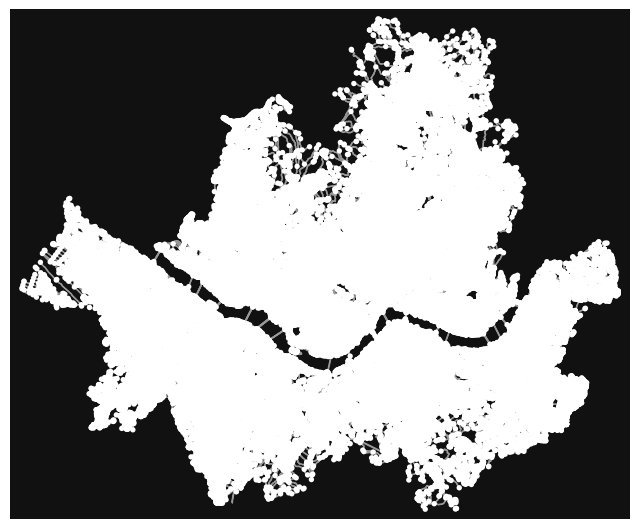

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# 서울시 그래프 맵 로드
print(f'\n서울시 그래프 맵 로드 - {datetime_now()}\n')
G = ox.graph_from_place('서울시, 대한민국', network_type='all')
ox.plot_graph(G)

In [15]:
# 지점 별 최단 노드 탐색
print(f'\n대피 경로 탐색 중 - {datetime_now()}\n')
school_df['학교_노드'] = school_df.apply(find_nearest_node, G=G, col1='학교_위도', col2='학교_경도', axis=1)
school_df['대피소_노드'] = school_df.apply(find_nearest_node, G=G, col1='대피소_위도', col2='대피소_경도', axis=1)
isna_some_cnt(['학교_노드', '대피소_노드'], school_df)


대피 경로 탐색 중 - 2025-02-19 10:56:13


학교_노드 없는 개수: 0
대피소_노드 없는 개수: 0


In [16]:
# 노드 간 최단 경로 탐색
school_df['최단_대피_경로'] = school_df.apply(shortest_path, G=G, axis=1)
isna_some_cnt(['최단_대피_경로',], school_df, is_iterable=True)

No path between 6789544588 and 3724646169.
No path between 11195672474 and 7068017163.

최단_대피_경로 없는 개수: 2


In [17]:
# 최단 경로 대피 거리 및 소요 시간 계산
print(f'\n대피 시간 계산 중 - {datetime_now()}\n')
school_df['총_대피_거리'] = None
school_df['예상_소요_시간(분)'] = None
school_df['총_대피_거리'] = school_df['최단_대피_경로'].apply(whole_distance, G=G)
school_df['예상_소요_시간(분)'] = round((school_df['총_대피_거리'] / (56.5)), 2)
school_df.to_csv(SAV_PATH + 'school_evacuation.csv', index=False, encoding='utf-8-sig')


대피 시간 계산 중 - 2025-02-19 11:02:18



In [22]:
# 산출된 데이터프레임 파일로 저장
school_df_dropna = school_df.dropna()
school_df_asc = school_df_dropna.sort_values(by='예상_소요_시간(분)', ascending=True)
school_df_desc = school_df_dropna.sort_values(by='예상_소요_시간(분)', ascending=False)
school_df_asc.head(10).to_csv(SAV_PATH + 'top_school_evacuation.csv', index=False, encoding='utf-8-sig')
school_df_desc.head(10).to_csv(SAV_PATH + 'bottom_school_evacuation.csv', index=False, encoding='utf-8-sig')

In [23]:
school_df_asc.head(5)

,학교명,학교_위도,학교_경도,대피소명,대피소_위도,대피소_경도,학교_노드,대피소_노드,최단_대피_경로,총_대피_거리,예상_소요_시간(분)
520,서울염리초등학교,37.542395,126.945859,정우빌딩(지하2층 주차장),37.542258,126.947183,4591258866,4591258866,[4591258866],0.0,0.0
77,서울남사초등학교,37.482531,126.978872,사당1동주민센터 지하주차장 1층,37.483006,126.97877,1685616447,1685616447,[1685616447],0.0,0.0
114,서울신가초등학교,37.502553,127.116831,송파2동주민센터 지하1층 헬스장 및 서고,37.502358,127.116741,1809635692,1809635692,[1809635692],0.0,0.0
147,서울강일초등학교,37.565018,127.177249,강일초등학교,37.56509,127.177633,3010115735,3010115735,[3010115735],0.0,0.0
191,서울미양초등학교,37.620935,127.013670,우이신설경전철-솔샘역(지하3~4층),37.620314,127.013618,4630094881,4630094881,[4630094881],0.0,0.0


In [24]:
school_df_desc.head(5)

,학교명,학교_위도,학교_경도,대피소명,대피소_위도,대피소_경도,학교_노드,대피소_노드,최단_대피_경로,총_대피_거리,예상_소요_시간(분)
546,서울북한산초등학교,37.654144,126.950176,은평경찰서 지하1층,37.627866,126.929129,1000120969,1000121066,"[1000120969, 439650117, 7295710154, 6475429004...",7322.597979,129.60
511,서울진관초등학교,37.645250,126.929074,은평경찰서 지하1층,37.627866,126.929129,5306636188,1000121066,"[5306636188, 5306636189, 11147760829, 53066361...",6504.305254,115.12
218,서울언남초등학교,37.453986,127.061488,현대1차아파트 현대상가지하 지하 1층,37.481997,127.054793,4632181927,436814266,"[4632181927, 4632181770, 4632162893, 509206149...",6305.673292,111.60
186,서울석계초등학교,37.608605,127.069795,하이텍빌딩(지하주차장 1층),37.610199,127.077571,1936512037,7579710687,"[1936512037, 7856357126, 436761795, 436761792,...",5749.691481,101.76
20,서울송원초등학교,37.554085,127.069438,용답동주민센터 지하1층,37.564147,127.055488,4177445736,10708182398,"[4177445736, 4177445717, 5935577739, 593557773...",4909.991772,86.90


In [25]:
# 소요시간 분석
mean_escape_time = school_df_dropna['예상_소요_시간(분)'].mean()
top_escape_time1 = school_df_asc.head(10)['예상_소요_시간(분)'].mean()
top_escape_df = school_df_asc.loc[school_df_asc['예상_소요_시간(분)'] > 10]
top_escape_time2 = top_escape_df.head(10)['예상_소요_시간(분)'].mean()
bottom_escape_time = school_df_desc.head(10)['예상_소요_시간(분)'].mean()
time_diff1 = bottom_escape_time - top_escape_time1
time_diff2 = bottom_escape_time - top_escape_time2

In [28]:
# 소요시간 관련 분석 결과 출력
mean_txt = f"전체 학교 대피시간 평균: {mean_escape_time}분\n"
mean_txt += f"상위 10개 학교 대피시간 평균1(0 포함): {top_escape_time1}분\n"
mean_txt += f"상위 10개 학교 대피시간 평균2(0 제외): {top_escape_time2}분\n"
mean_txt += f"하위 10개 학교 대피시간 평균: {bottom_escape_time}분\n"
mean_txt += f"상하위 학교 간 대피시간 평균 차이1(0 포함): {time_diff1}분\n"
mean_txt += f"상하위 학교 간 대피시간 평균 차이2(0 제외): {time_diff2}분\n"
print('\n' + mean_txt)


전체 학교 대피시간 평균: 19.612302631578945분
상위 10개 학교 대피시간 평균1(0 포함): 0.22400000000000003분
상위 10개 학교 대피시간 평균2(0 제외): 10.216999999999999분
하위 10개 학교 대피시간 평균: 89.98600000000002분
상하위 학교 간 대피시간 평균 차이1(0 포함): 89.76200000000001분
상하위 학교 간 대피시간 평균 차이2(0 제외): 79.76900000000002분



In [29]:
with open(SAV_PATH + 'escape_time.txt', 'w', encoding='utf-8') as f:
    f.write(mean_txt)